# 1- Limpieza y creación de features

In [1]:
import pandas as pd

df = pd.read_csv("../data/comentarios_analizados.csv")

In [2]:
df.drop({"Unnamed: 0", "TOXICITY"}, axis=1, inplace=True)
df.rename({"text_x":"text"}, axis=1, inplace=True)

df.drop_duplicates(subset ='text', keep = False, inplace = True)
df = df.loc[df.canal != "SimpDNimu"]


In [3]:
df.shape

(1279806, 25)

Binarizo todo de acuerdo al threshold

In [14]:
toxicity_fields = [
    "toxicity",
    "THREAT_EXPERIMENTAL",
    "IDENTITY_ATTACK_EXPERIMENTAL",
    "INSULT_EXPERIMENTAL",
    "PROFANITY_EXPERIMENTAL",
    "SEVERE_TOXICITY",
]

engagement_fields = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

threshold = 0.8

df.loc[:, toxicity_fields] = df.loc[:, toxicity_fields] > threshold

Hasta acá, df es de comentarios, ahora con los valores binarizados.

Queremos un df por video 

Tomo la suma en el caso de los replyCounts y likeCounts (son a nivel comentario) y el primero para cada video

**CHEQUEAR ESTO!**

In [15]:
df_video = df.groupby("videoId").agg({
    **{k:"mean" for k in toxicity_fields},
    **{k:"sum" for k in ['replyCount', 'likeCount']},
    **{k:"first" for k in ['likes_video', 'vistas_video', 'cantidad_comentarios', 'canal']}
})

In [16]:
df_video["canal"].unique()

array(['Rodriguez Galati', 'NICO VILLA', 'maritobaracus', 'FFran Gomez',
       'Nimu', 'AleVera Oficial', 'Tincho Ruiz', 'Romi', 'PassThor',
       'Hecatombe Producciones', 'Melina Vallejos', 'Guille Aquino'],
      dtype=object)

In [17]:
youtubers = df_video["canal"].unique()
zscore_fields = [
    'toxicity', 'SEVERE_TOXICITY' ,'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

for field in zscore_fields:
    zscore_name = "z_" + field
    print(field)
    for youtuber in youtubers:
        values = df_video.loc[df_video["canal"] == youtuber, field]
        mean = values.mean()
        std = values.std()
        df_video.loc[df_video["canal"] == youtuber, zscore_name] = ((values - mean) / std).values

    


toxicity
SEVERE_TOXICITY
replyCount
likeCount
likes_video
vistas_video
cantidad_comentarios


In [18]:
df_video.insert(1, "z_toxicity", df_video.pop("z_toxicity"))
df_video.insert(2, "z_SEVERE_TOXICITY", df_video.pop("z_SEVERE_TOXICITY"))

<AxesSubplot:>

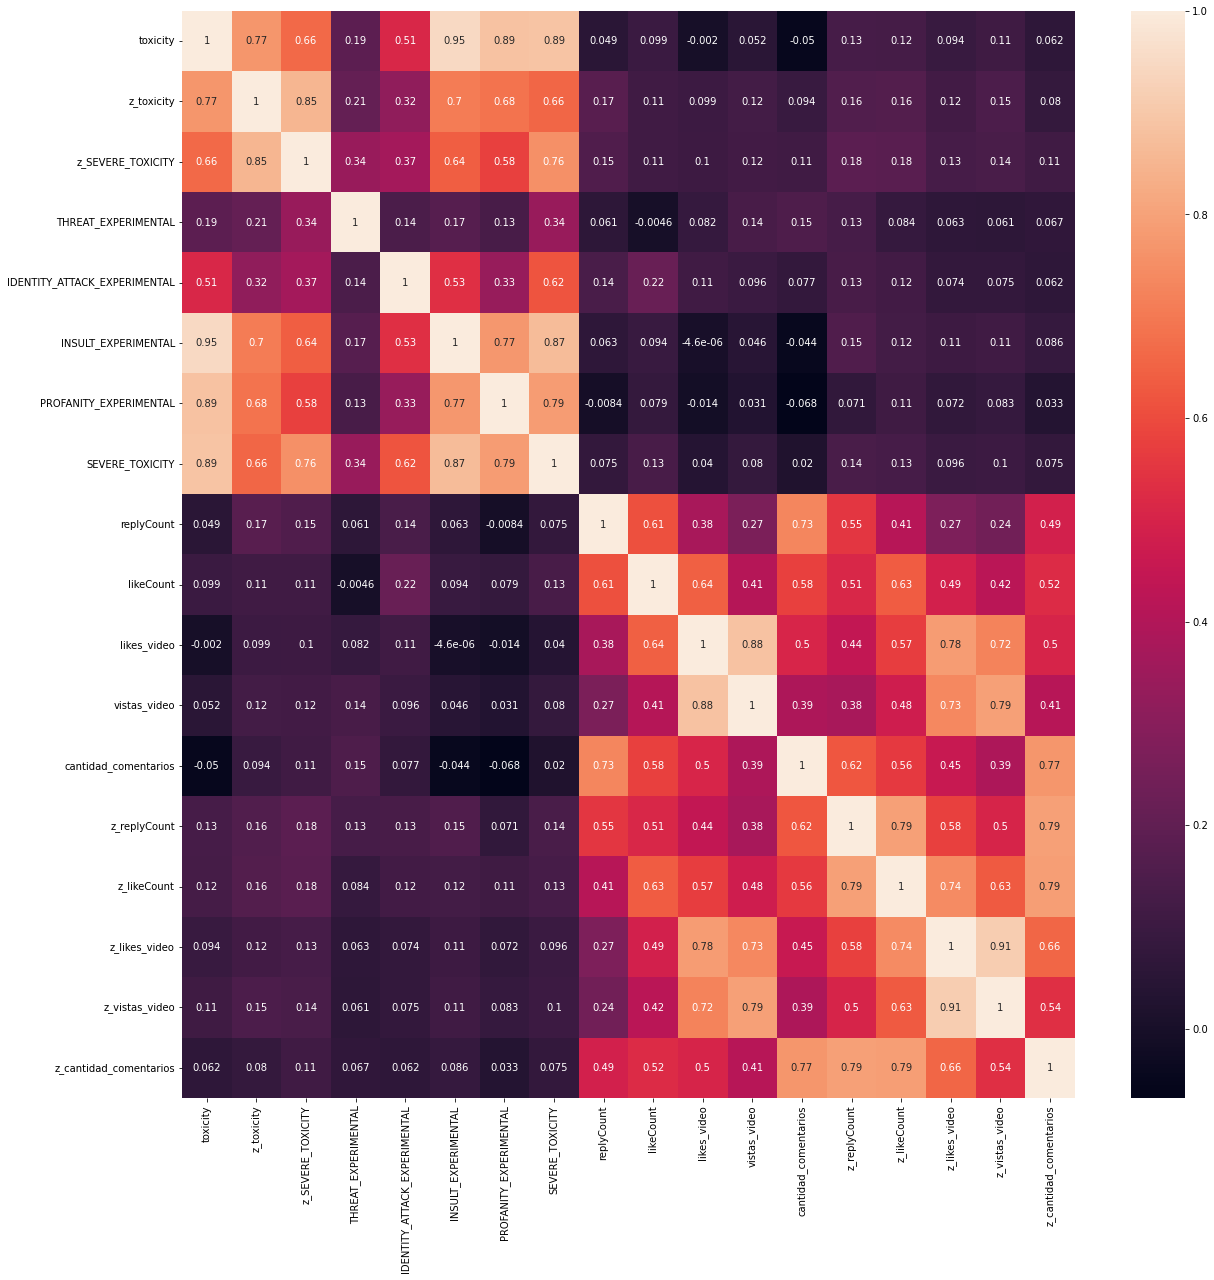

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(20,20))

sns.heatmap(data=df_video.corr(), annot=True)

## Cómicos

<AxesSubplot:>

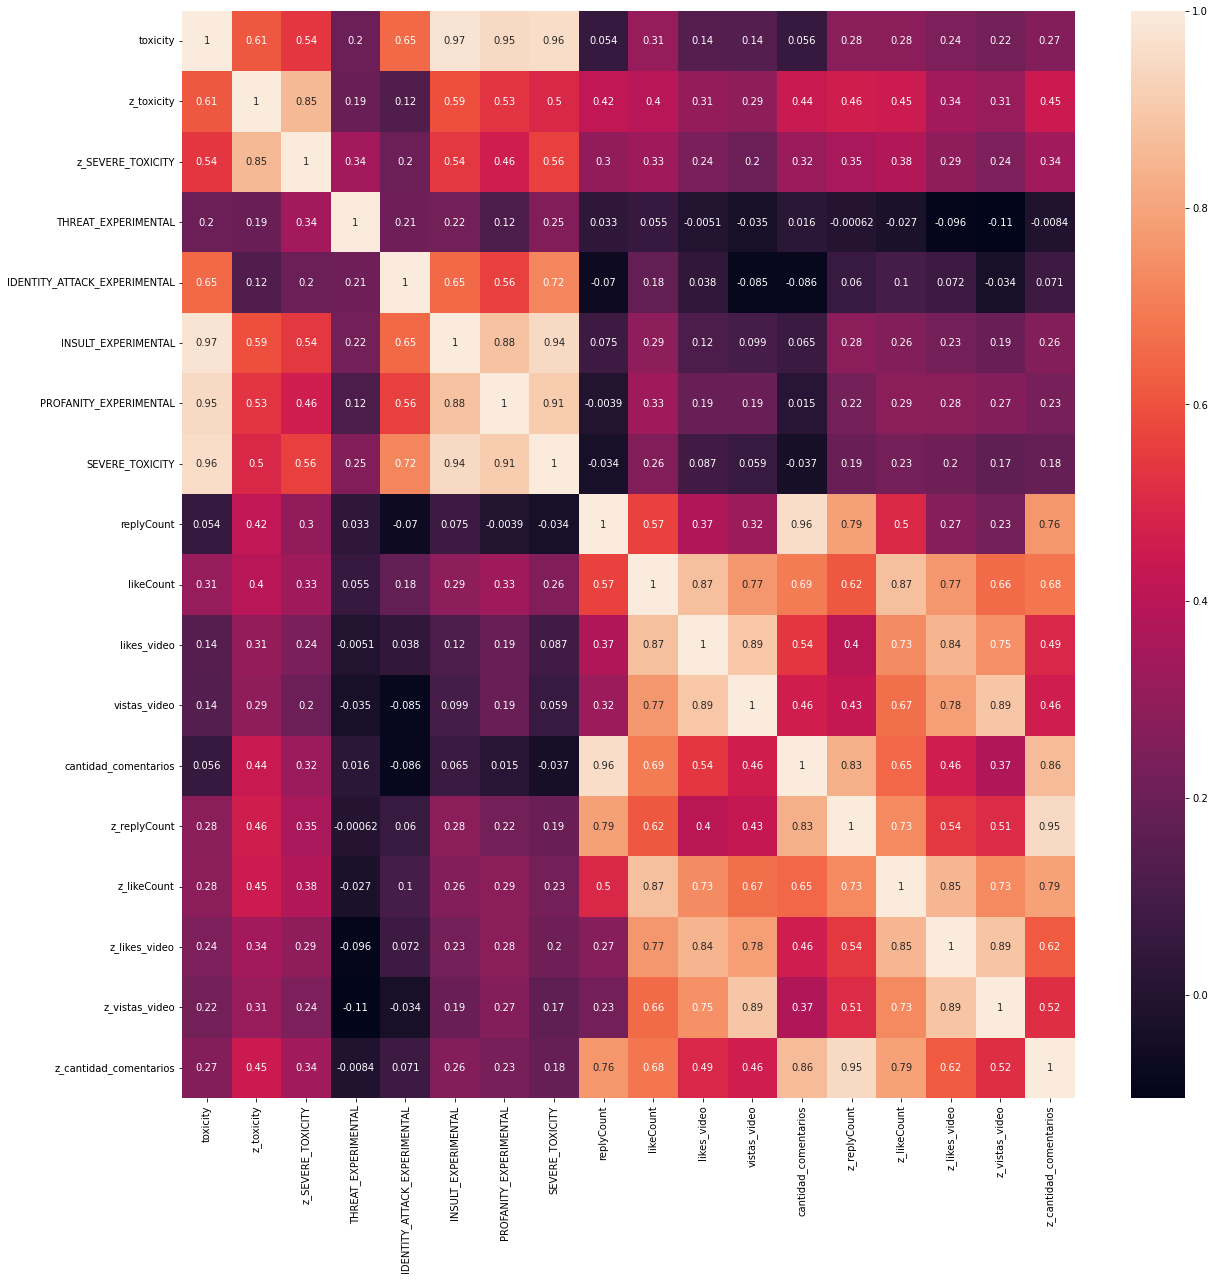

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
comicos = ["maritobaracus", 'AleVera Oficial', "Nimu"]

plt.figure(figsize=(20,20))

df_video_comicos = df_video.loc[df_video["canal"].isin(comicos)]

sns.heatmap(data=df_video_comicos.corr(), annot=True)

<AxesSubplot:>

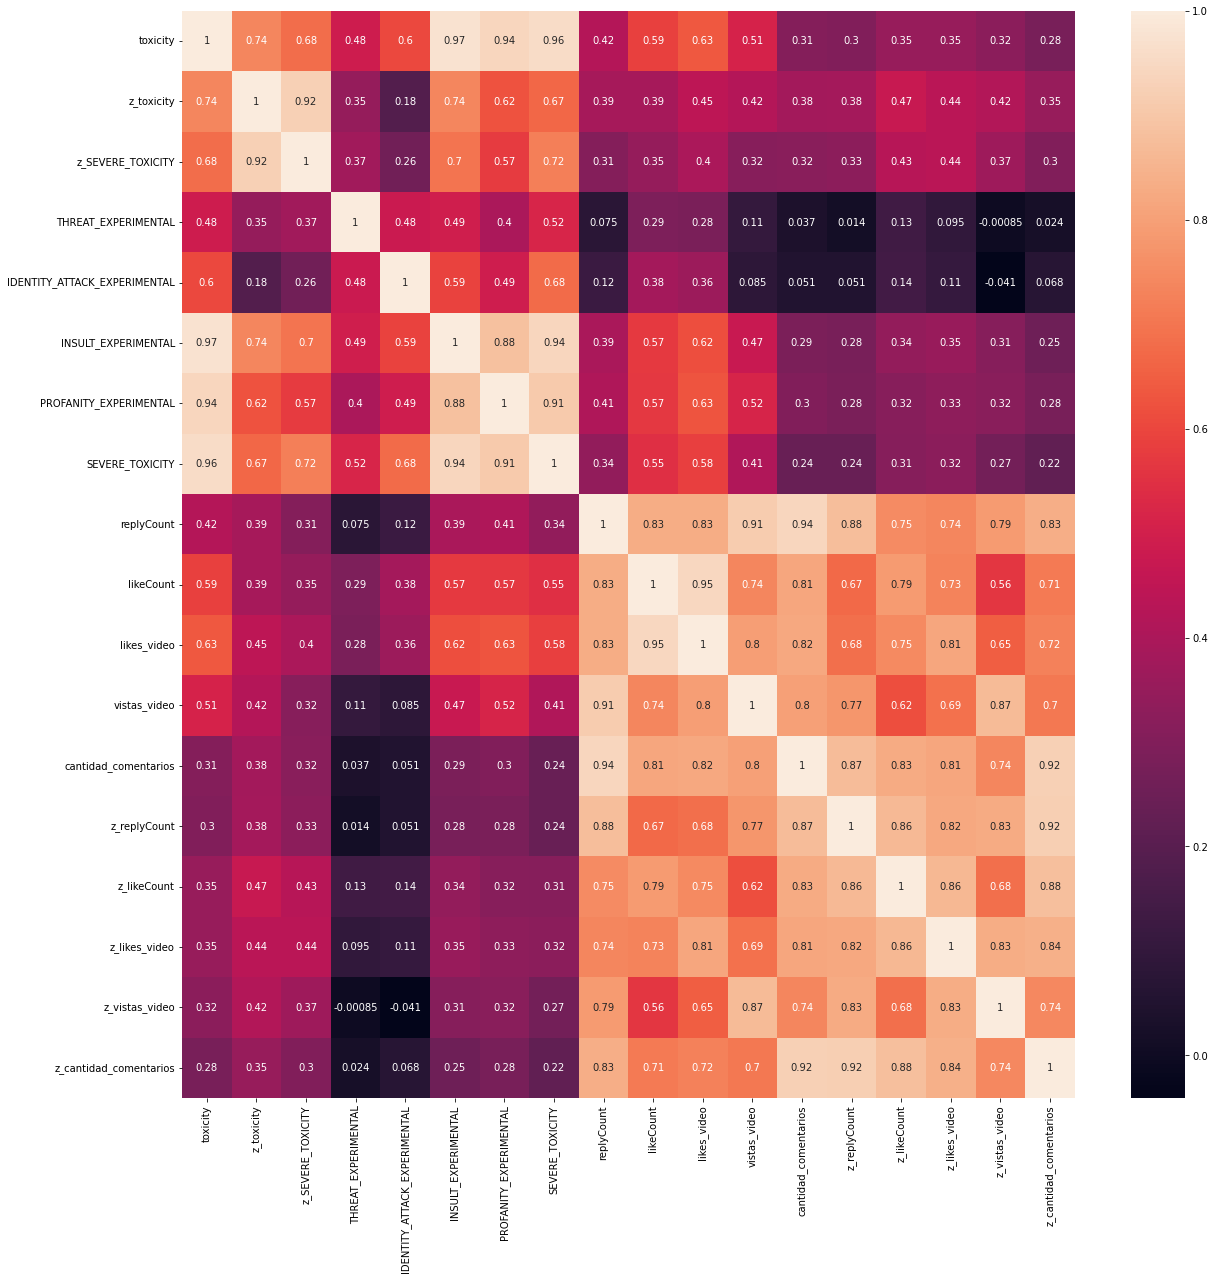

In [23]:

comicos = ["maritobaracus", 'AleVera Oficial']

plt.figure(figsize=(20,20))

df_video_comicos = df_video.loc[df_video["canal"].isin(comicos)]

sns.heatmap(data=df_video_comicos.corr(), annot=True)

In [22]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues.astype(float)

<AxesSubplot:>

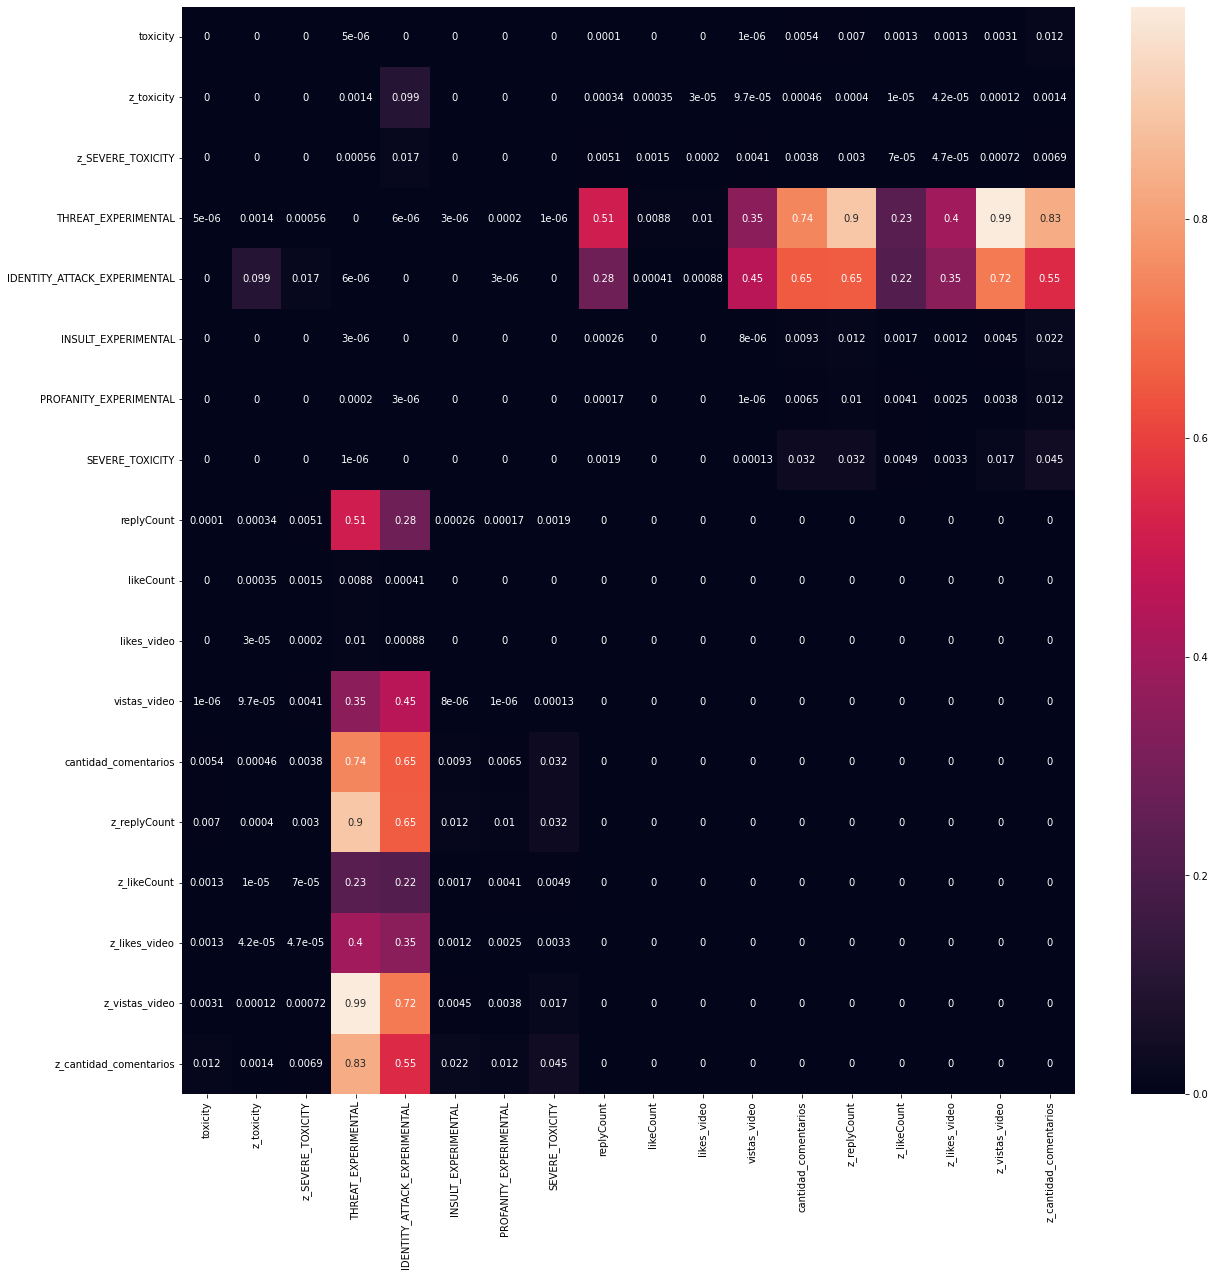

In [13]:

plt.figure(figsize=(20,20))


sns.heatmap(data=calculate_pvalues(df_video_comicos), annot=True)